In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for better visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [7]:
# --- Data Loading ---
try:
    df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: Please check the file path.")

# Display the first few rows
print("\n--- Initial Data Head ---")
print(df.head())

# Display data structure and types (Data Structure KPI)
print("\n--- Data Information ---")
print(df.info())

C:\Users\YODAHE\AppData\Local\Temp\ipykernel_14636\2310512155.py:3: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/MachineLearningRating_v3.txt', sep='|')


Data loaded successfully.

--- Initial Data Head ---
   UnderwrittenCoverID  PolicyID     TransactionMonth  IsVATRegistered  \
0               145249     12827  2015-03-01 00:00:00             True   
1               145249     12827  2015-05-01 00:00:00             True   
2               145249     12827  2015-07-01 00:00:00             True   
3               145255     12827  2015-05-01 00:00:00             True   
4               145255     12827  2015-07-01 00:00:00             True   

  Citizenship          LegalType Title Language                 Bank  \
0              Close Corporation    Mr  English  First National Bank   
1              Close Corporation    Mr  English  First National Bank   
2              Close Corporation    Mr  English  First National Bank   
3              Close Corporation    Mr  English  First National Bank   
4              Close Corporation    Mr  English  First National Bank   

       AccountType  ...                    ExcessSelected CoverCatego

In [9]:
# --- Convert to Correct Data Types (Fixing KeyError) ---
# Correct column name is 'TransactionMonth'
df['TransactionMonth'] = pd.to_datetime(df['TransactionMonth'])

# Ensure financial columns are numeric
financial_cols = ['TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'SumInsured']
for col in financial_cols:
    # Use errors='coerce' to turn any non-numeric mixed type values into NaN
    df[col] = pd.to_numeric(df[col], errors='coerce') 

# --- Data Quality Check: Missing Values ---
print("\n--- Missing Value Assessment ---")
missing_summary = df.isnull().sum().sort_values(ascending=False)
print(missing_summary[missing_summary > 0])

# Continue with the rest of your EDA code...


--- Missing Value Assessment ---
NumberOfVehiclesInFleet    1000098
CrossBorder                 999400
CustomValueEstimate         779642
Rebuilt                     641901
Converted                   641901
WrittenOff                  641901
NewVehicle                  153295
Bank                        145961
AccountType                  40232
Gender                        9536
MaritalStatus                 8259
VehicleType                    552
make                           552
mmcode                         552
Model                          552
Cylinders                      552
bodytype                       552
kilowatts                      552
NumberOfDoors                  552
VehicleIntroDate               552
cubiccapacity                  552
CapitalOutstanding               2
dtype: int64


In [10]:
# --- Feature Engineering: Calculate Loss Ratio ---
# We calculate the loss ratio for each policy.
# Use a small epsilon to avoid division by zero for policies with 0 premium, 
# although in insurance, TotalPremium should generally be > 0.
epsilon = 1e-6
df['LossRatio'] = df['TotalClaims'] / (df['TotalPremium'] + epsilon)

# Note: The overall portfolio Loss Ratio is calculated by summing TotalClaims 
# and TotalPremium across all policies, not by averaging the LossRatio column.
# This ensures accuracy by accounting for policies with very low premiums.

overall_claims = df['TotalClaims'].sum()
overall_premium = df['TotalPremium'].sum()
overall_loss_ratio = overall_claims / overall_premium

print(f"\n--- Overall Portfolio Loss Ratio ---")
print(f"Total Claims: {overall_claims:,.2f} | Total Premium: {overall_premium:,.2f}")
print(f"Overall Portfolio Loss Ratio (Total Claims / Total Premium): {overall_loss_ratio:.4f}")


--- Overall Portfolio Loss Ratio ---
Total Claims: 64,867,546.17 | Total Premium: 61,911,562.70
Overall Portfolio Loss Ratio (Total Claims / Total Premium): 1.0477


In [11]:
# --- Aggregate Loss Ratio by Key Risk Drivers ---

def calculate_group_loss_ratio(group_col):
    """Calculates the accurate aggregate Loss Ratio for a given grouping column."""
    risk_by_group = df.groupby(group_col).agg(
        TotalClaims=('TotalClaims', 'sum'),
        TotalPremium=('TotalPremium', 'sum')
    ).reset_index()
    
    # Calculate group Loss Ratio (sum of claims / sum of premiums)
    risk_by_group['LossRatio'] = risk_by_group['TotalClaims'] / risk_by_group['TotalPremium']
    
    # Sort and return the top/bottom 10 for review
    return risk_by_group.sort_values(by='LossRatio', ascending=False)

# 1. Loss Ratio by Province
province_risk = calculate_group_loss_ratio('Province')
print("\n--- Loss Ratio by Province (Top 5) ---")
print(province_risk.head(5))

# 2. Loss Ratio by Vehicle Type
vehicle_type_risk = calculate_group_loss_ratio('VehicleType')
print("\n--- Loss Ratio by VehicleType (Top 5) ---")
print(vehicle_type_risk.head(5))

# 3. Loss Ratio by Gender
gender_risk = calculate_group_loss_ratio('Gender')
print("\n--- Loss Ratio by Gender ---")
print(gender_risk)


--- Loss Ratio by Province (Top 5) ---
        Province   TotalClaims  TotalPremium  LossRatio
2        Gauteng  2.939415e+07  2.405377e+07   1.222018
3  KwaZulu-Natal  1.430138e+07  1.320908e+07   1.082693
8   Western Cape  1.038977e+07  9.806559e+06   1.059472
6     North West  5.920250e+06  7.490508e+06   0.790367
5     Mpumalanga  2.044675e+06  2.836292e+06   0.720897

--- Loss Ratio by VehicleType (Top 5) ---
         VehicleType   TotalClaims  TotalPremium  LossRatio
1   Heavy Commercial  7.504746e+05  4.609479e+05   1.628112
3  Medium Commercial  4.119867e+06  3.922746e+06   1.050251
4  Passenger Vehicle  5.937207e+07  5.664202e+07   1.048198
2   Light Commercial  6.045250e+04  2.604975e+05   0.232066
0                Bus  7.996535e+03  5.824474e+04   0.137292

--- Loss Ratio by Gender ---
          Gender   TotalClaims  TotalPremium  LossRatio
2  Not specified  6.271410e+07  5.920275e+07   1.059311
1           Male  1.396704e+06  1.580143e+06   0.883910
0         Female  2.502

C:\Users\YODAHE\AppData\Local\Temp\ipykernel_14636\1433639709.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


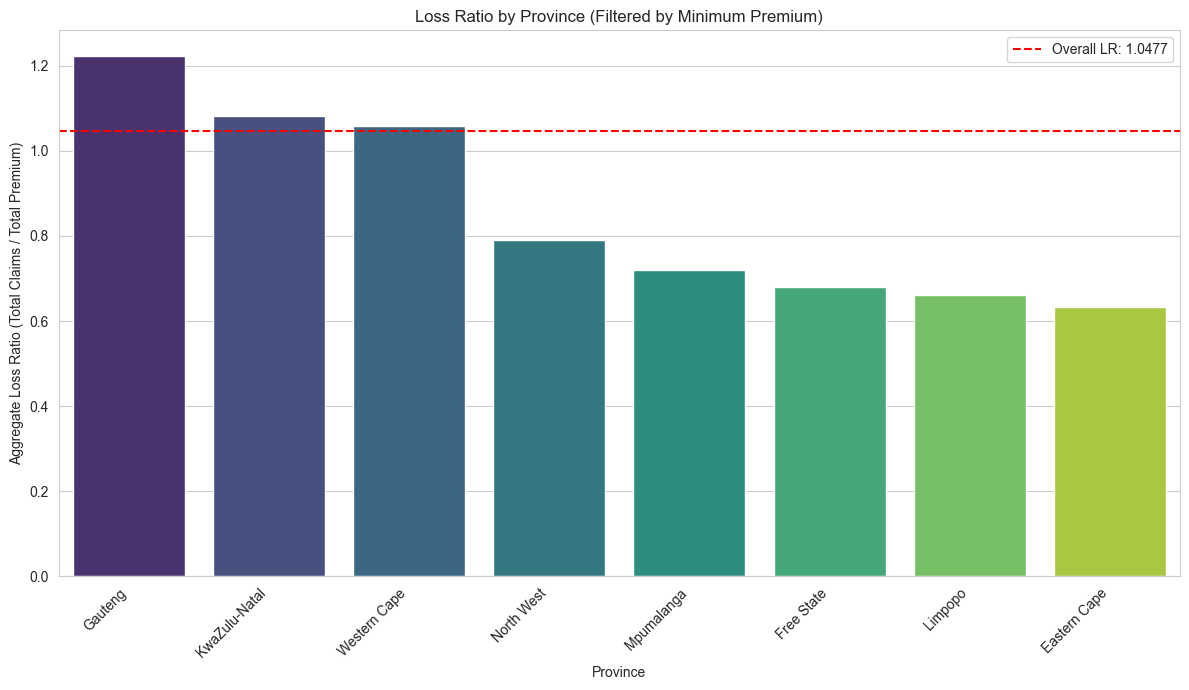

In [12]:
# --- Creative Plot 1: Loss Ratio by Province ---
# Filter out provinces with very low premium (low data volume) for stable visualization
province_risk_clean = province_risk[province_risk['TotalPremium'] > province_risk['TotalPremium'].quantile(0.1)]

plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x='Province', 
    y='LossRatio', 
    data=province_risk_clean,
    palette='viridis' # Use a distinct color palette
)

# Add the overall portfolio Loss Ratio as a benchmark line
ax.axhline(overall_loss_ratio, color='r', linestyle='--', label=f'Overall LR: {overall_loss_ratio:.4f}')

plt.title('Loss Ratio by Province (Filtered by Minimum Premium)')
plt.ylabel('Aggregate Loss Ratio (Total Claims / Total Premium)')
plt.xlabel('Province')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

#